In [7]:
# Lib Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import category_encoders as ce

In [8]:
# Setting Pandas column display option
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [9]:
%%time
idee = pd.read_csv('train_identity.csv')
transaction = pd.read_csv('train_transaction.csv')

Wall time: 18 s


In [10]:
%%time
def pipeline(idee, transaction):
    merge = transaction.merge(idee, how='outer', on='TransactionID')
    objects = merge.select_dtypes('object')
    objects = objects.join(merge[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']])
    objects['isFraud'] = merge['isFraud']
    objects.fillna("Unknown", inplace=True)
    objects = objects.astype('category')
    print(objects.info())
    return objects
objects = pipeline(idee,transaction)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      590540 non-null  category
 1   card4          590540 non-null  category
 2   card6          590540 non-null  category
 3   P_emaildomain  590540 non-null  category
 4   R_emaildomain  590540 non-null  category
 5   M1             590540 non-null  category
 6   M2             590540 non-null  category
 7   M3             590540 non-null  category
 8   M4             590540 non-null  category
 9   M5             590540 non-null  category
 10  M6             590540 non-null  category
 11  M7             590540 non-null  category
 12  M8             590540 non-null  category
 13  M9             590540 non-null  category
 14  id_12          590540 non-null  category
 15  id_15          590540 non-null  category
 16  id_16          590540 non-null  category
 17  id_23     

In [11]:
objects.drop(columns=['M4','id_15','id_16','id_28','id_29','id_35','id_36','id_38','DeviceType','DeviceInfo'], inplace=True)
objects.shape

(590540, 18)

In [12]:
#value_counts_list = []
#obj_columns_list = objects.columns.to_list()
#for column in obj_columns_list:
    #df = objects[column].value_counts().reset_index()
    #value_counts_list.append(df)

#objects_value_counts_df = pd.concat(value_counts_list, axis=1)
#objects_value_counts_df.shape

In [13]:
%%time
X  = objects.drop(columns='isFraud')
y = objects['isFraud'].astype('int')

under = RandomUnderSampler(sampling_strategy=0.8) 
over = RandomOverSampler(sampling_strategy=0.5)
# sm = SMOTE()
# ad = ADASYN()
# lasso = LassoCV(tol=0.01, n_jobs=-1)

#X_rus, y_rus = under.fit_resample(X, y)
X_ros, y_ros = over.fit_resample(X, y)
# X_sm, y_sm = sm.fit_resample(X, y)
# X_ad, y_ad = ad.fit_resample(X, y)
X_cs, y_cs = under.fit_resample(X_ros, y_ros)
# del X_ros, y_ros

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    return X_train, X_test, y_train, y_test

logit = LogisticRegression(
        penalty='l2', C=1e42, max_iter=150, verbose=1, solver='liblinear', n_jobs=-1)

Wall time: 3.9 s


In [14]:
X_train, X_test, y_train, y_test = split(X_cs, y_cs)

columns = X_train.columns.to_list()

def get_score(model, X, y, X_test, y_test):
    model.fit(X, y)
    y_pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_pred)
    return score

In [15]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(448777, 17) (192333, 17) (448777,) (192333,)


In [16]:
%%time
n_components_list = np.arange(1500, 1800, 50).tolist()
n_components_list_str = [str(i) for i in n_components_list]

fh_logit_scores = []

for n_components in n_components_list:
    hashing_enc = ce.HashingEncoder(cols=columns, n_components=n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    
    fe_logit_score = get_score(logit, X_train_hashing, y_train, X_test_hashing, y_test)
    fh_logit_scores.append(fe_logit_score)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Wall time: 43min 48s


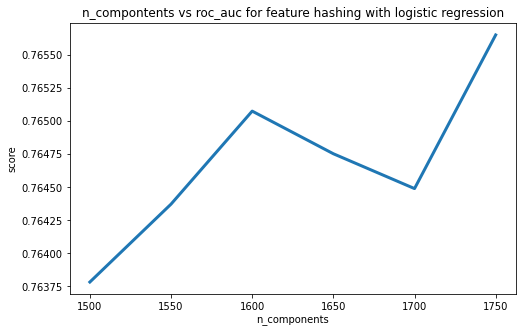

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_logit_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show()

In [18]:
fh_logit_scores

[0.7637804978229207,
 0.7643697477776963,
 0.7650732560032814,
 0.7647508243985015,
 0.7644873578581671,
 0.7656494042152038]

In [19]:
growth_rate = np.exp(np.diff(np.log(fh_logit_scores))) - 1

In [20]:
growth_rate

array([ 0.00077149,  0.00092038, -0.00042144, -0.00034451,  0.00152003])

## Test dataset benchmarking

In [14]:
%%time
hashing_enc = ce.HashingEncoder(cols=columns, n_components=2000, max_process=4).fit(X_train, y_train)
X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
print(X_train_hashing.shape, y_train.shape)

(28928, 2000) (28928,)
Wall time: 58 s


In [15]:
%%time
idee_test = pd.read_csv('test_identity.csv')
transaction_test = pd.read_csv('test_transaction.csv') 
merge_test = transaction_test.merge(idee_test, how='outer', on='TransactionID')
objects_test = merge_test.select_dtypes('object')
objects_test.fillna("Unknown", inplace=True)
objects_test = objects_test.astype('category')
objects_test.columns = X_train.columns
print(objects_test.info())
del idee_test, transaction_test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      506691 non-null  category
 1   card4          506691 non-null  category
 2   card6          506691 non-null  category
 3   P_emaildomain  506691 non-null  category
 4   R_emaildomain  506691 non-null  category
 5   M1             506691 non-null  category
 6   M2             506691 non-null  category
 7   M3             506691 non-null  category
 8   M4             506691 non-null  category
 9   M5             506691 non-null  category
 10  M6             506691 non-null  category
 11  M7             506691 non-null  category
 12  M8             506691 non-null  category
 13  M9             506691 non-null  category
 14  id_12          506691 non-null  category
 15  id_15          506691 non-null  category
 16  id_16          506691 non-null  category
 17  id_23     

In [16]:
X2_hashed = hashing_enc.transform(objects_test.reset_index(drop=True), override_return_df=True)

In [17]:
%%time
X2_hashed.head()

Wall time: 1 ms


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_114,col_115,col_116,col_117,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,col_129,col_130,col_131,col_132,col_133,col_134,col_135,col_136,col_137,col_138,col_139,col_140,col_141,col_142,col_143,col_144,col_145,col_146,col_147,col_148,col_149,col_150,col_151,col_152,col_153,col_154,col_155,col_156,col_157,col_158,col_159,col_160,col_161,col_162,col_163,col_164,col_165,col_166,col_167,col_168,col_169,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179,col_180,col_181,col_182,col_183,col_184,col_185,col_186,col_187,col_188,col_189,col_190,col_191,col_192,col_193,col_194,col_195,col_196,col_197,col_198,col_199,col_200,col_201,col_202,col_203,col_204,col_205,col_206,col_207,col_208,col_209,col_210,col_211,col_212,col_213,col_214,col_215,col_216,col_217,col_218,col_219,col_220,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,col_235,col_236,col_237,col_238,col_239,col_240,col_241,col_242,col_243,col_244,col_245,col_246,col_247,col_248,col_249,...,col_1750,col_1751,col_1752,col_1753,col_1754,col_1755,col_1756,col_1757,col_1758,col_1759,col_1760,col_1761,col_1762,col_1763,col_1764,col_1765,col_1766,col_1767,col_1768,col_1769,col_1770,col_1771,col_1772,col_1773,col_1774,col_1775,col_1776,col_1777,col_1778,col_1779,col_1780,col_1781,col_1782,col_1783,col_1784,col_1785,col_1786,col_1787,col_1788,col_1789,col_1790,col_1791,col_1792,col_1793,col_1794,col_1795,col_1796,col_1797,col_1798,col_1799,col_1800,col_1801,col_1802,col_1803,col_1804,col_1805,col_1806,col_1807,col_1808,col_1809,col_1810,col_1811,col_1812,col_1813,col_1814,col_1815,col_1816,col_1817,col_1818,col_1819,col_1820,col_1821,col_1822,col_1823,col_1824,col_1825,col_1826,col_1827,col_1828,col_1829,col_1830,col_1831,col_1832,col_1833,col_1834,col_1835,col_1836,col_1837,col_1838,col_1839,col_1840,col_1841,col_1842,col_1843,col_1844,col_1845,col_1846,col_1847,col_1848,col_1849,col_1850,col_1851,col_1852,col_1853,col_1854,col_1855,col_1856,col_1857,col_1858,col_1859,col_1860,col_1861,col_1862,col_1863,col_1864,col_1865,col_1866,col_1867,col_1868,col_1869,col_1870,col_1871,col_1872,col_1873,col_1874,col_1875,col_1876,col_1877,col_1878,col_1879,col_1880,col_1881,col_1882,col_1883,col_1884,col_1885,col_1886,col_1887,col_1888,col_1889,col_1890,col_1891,col_1892,col_1893,col_1894,col_1895,col_1896,col_1897,col_1898,col_1899,col_1900,col_1901,col_1902,col_1903,col_1904,col_1905,col_1906,col_1907,col_1908,col_1909,col_1910,col_1911,col_1912,col_1913,col_1914,col_1915,col_1916,col_1917,col_1918,col_1919,col_1920,col_1921,col_1922,col_1923,col_1924,col_1925,col_1926,col_1927,col_1928,col_1929,col_1930,col_1931,col_1932,col_1933,col_1934,col_1935,col_1936,col_1937,col_1938,col_1939,col_1940,col_1941,col_1942,col_1943,col_1944,col_1945,col_1946,col_1947,col_1948,col_1949,col_1950,col_1951,col_1952,col_1953,col_1954,col_1955,col_1956,col_1957,col_1958,col_1959,col_1960,col_1961,col_1962,col_1963,col_1964,col_1965,col_1966,col_1967,col_1968,col_1969,col_1970,col_1971,col_1972,col_1973,col_1974,col_1975,col_1976,col_1977,col_1978,col_1979,col_1980,col_1981,col_1982,col_1983

In [18]:
%%time
logit.fit(X_train_hashing, y_train)
y_pred_train = logit.predict(X_test_hashing)
from sklearn.metrics import classification_report
print(classification_report(y_pred_train, y_test))

[LibLinear]              precision    recall  f1-score   support

           0       0.78      0.68      0.73      6999
           1       0.65      0.76      0.70      5399

    accuracy                           0.72     12398
   macro avg       0.72      0.72      0.71     12398
weighted avg       0.73      0.72      0.72     12398

Wall time: 4.87 s


In [19]:
%%time
y_pred = logit.predict(X2_hashed)

Wall time: 6.42 s


In [20]:
y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)